# 📊 Portfolio Analysis and Sharpe Ratio Optimization

**Author:** Yanis Calvo  
**Date:** November 2024

---

## Project Overview

This notebook analyzes the performance of 4 major tech stocks (AAPL, GOOGL, TSLA, MSFT) 
and optimizes a portfolio by maximizing the **Sharpe Ratio**.

### Table of Contents
1. Import Libraries
2. Data Download and Cleaning
3. Financial Metrics Calculation
4. Visualizations
5. Portfolio Optimization

## 1. Import Libraries

In [1]:
# =============================================================================
# LIBRARY IMPORTS
# =============================================================================

# Stock data download
import yfinance as yf

# Data manipulation and analysis
import pandas as pd
import numpy as np

# US holidays management
import holidays

# Data visualization
import matplotlib.pyplot as plt

# Mathematical optimization
from scipy.optimize import minimize

# Suppress warnings for cleaner output
import warnings

warnings.filterwarnings("ignore")

# Configure plot style
plt.style.use("seaborn-v0_8-whitegrid")

/Users/yanis.calvo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 2. Data Download and Cleaning

In [2]:
# =============================================================================
# CONFIGURATION PARAMETERS
# =============================================================================

# List of tech stocks to analyze
TICKERS = ["AAPL", "GOOGL", "TSLA", "MSFT"]

# Analysis period: 3 years of historical data
START_DATE = "2022-01-01"
END_DATE = "2025-01-01"

# Annual risk-free rate (US T-Bills approximation)
RISK_FREE_RATE = 0.02

# Number of trading days per year (financial convention)
TRADING_DAYS_PER_YEAR = 252

# Rolling window for volatility calculation
VOLATILITY_WINDOW = 30

In [3]:
# =============================================================================
# DOWNLOAD STOCK DATA
# =============================================================================

# Download data via Yahoo Finance API
# Data includes: Open, High, Low, Close, Volume, Adj Close
raw_data = yf.download(TICKERS, start=START_DATE, end=END_DATE)

# Select relevant columns for our analysis
# - Close: closing price (used to calculate returns)
# - Open: opening price
# - Volume: number of shares traded
data = raw_data[["Close", "Open", "Volume"]]

# Transform multi-index DataFrame to "long" format
# Before: columns = (Close, AAPL), (Close, GOOGL), ...
# After: columns = Date, Ticker, Close, Open, Volume
data = data.stack(level=1).reset_index()
data.columns = ["Date", "Ticker", "Close", "Open", "Volume"]

# Ensure Date column is in datetime format
data["Date"] = pd.to_datetime(data["Date"])

print(f"Data downloaded: {len(data)} rows")
print(f"Period: {data['Date'].min().date()} to {data['Date'].max().date()}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed

Data downloaded: 3012 rows
Period: 2022-01-03 to 2024-12-31


In [4]:
# =============================================================================
# FILTER OUT US HOLIDAYS
# =============================================================================

# US stock markets are closed on federal holidays
# Retrieve list of US holidays for our analysis period
us_holidays = holidays.US(years=range(2022, 2026))

# Convert to DataFrame for easier merging
holidays_df = pd.DataFrame(
    list(us_holidays.items()), 
    columns=["Date", "HolidayName"]
)
holidays_df["Date"] = pd.to_datetime(holidays_df["Date"])

# LEFT join: keep all our data and add holiday name if applicable
data = pd.merge(data, holidays_df, how="left", on="Date")

# Create boolean column: True = trading day (not a holiday)
data["is_trading_day"] = data["HolidayName"].isna()

# Filter: keep only actual trading days
data = data[data["is_trading_day"] == True].copy()

# Cleanup: remove temporary columns
data = data.drop(columns=["HolidayName", "is_trading_day"])

print(f"After filtering holidays: {len(data)} rows")
data.head()

After filtering holidays: 2988 rows


,Date,Ticker,Close,Open,Volume
0,2022-01-03,AAPL,178.270325,174.176216,104487900
1,2022-01-03,GOOGL,143.904190,143.967206,28646000
2,2022-01-03,MSFT,323.898407,324.478963,28865100
3,2022-01-03,TSLA,399.926666,382.583344,103931400
4,2022-01-04,AAPL,176.007797,178.877604,99310400


## 3. Financial Metrics Calculation

### Formulas Used

**Simple Return:**
$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$

**Logarithmic Return:**
$$R_{log,t} = \ln\left(\frac{P_t}{P_{t-1}}\right)$$

**Cumulative Return:**
$$R_{cum} = \prod_{i=1}^{t}(1 + R_i)$$

**Annualized Volatility:**
$$\sigma_{ann} = \sigma_{daily} \times \sqrt{252}$$

In [5]:
# =============================================================================
# CALCULATE RETURNS AND FINANCIAL INDICATORS
# =============================================================================

# Simple (arithmetic) return: percentage change between two days
# Formula: R_t = (P_t - P_{t-1}) / P_{t-1}
data["Return"] = data.groupby("Ticker")["Close"].pct_change()

# Logarithmic return: preferred for quantitative modeling
# Advantage: log returns are additive over time
# Formula: R_log = ln(P_t / P_{t-1})
data["LogReturn"] = data.groupby("Ticker")["Close"].transform(
    lambda x: np.log(x / x.shift(1))
)

# Cumulative return: total performance since start
# Formula: R_cum = product(1 + R_i) for i = 1 to t
# Interpretation: if R_cum = 1.5, the investment gained 50%
data["CumulativeReturn"] = data.groupby("Ticker")["Return"].transform(
    lambda x: (1 + x).cumprod()
)

# Annualized volatility on 30-day rolling window
# Volatility measures risk: higher volatility = larger price fluctuations
# Formula: sigma_ann = sigma_daily * sqrt(252)
data["AnnualizedVolatility"] = data.groupby("Ticker")["Return"].transform(
    lambda x: x.rolling(window=VOLATILITY_WINDOW).std() * np.sqrt(TRADING_DAYS_PER_YEAR)
)

# Remove rows with missing values (first rows of each ticker)
data = data.dropna()

print(f"Enriched data: {len(data)} rows")
data.head(10)

Enriched data: 2868 rows


,Date,Ticker,Close,Open,Volume,Return,LogReturn,CumulativeReturn,AnnualizedVolatility
120,2022-02-15,AAPL,169.455368,167.670499,62527400,0.023152,0.022889,0.950553,0.306394
121,2022-02-15,GOOGL,135.584076,136.538852,26680000,0.007988,0.007956,0.942183,0.378187
122,2022-02-15,MSFT,290.729614,290.284534,27058300,0.018542,0.018373,0.897595,0.320761
123,2022-02-15,TSLA,307.476654,300.000000,57286200,0.053291,0.051919,0.768833,0.669344
124,2022-02-16,AAPL,169.220001,168.533513,61177400,-0.001389,-0.001390,0.949233,0.304556
125,2022-02-16,GOOGL,136.705109,135.621787,25022000,0.008268,0.008234,0.949973,0.379207
126,2022-02-16,MSFT,290.390289,289.294655,29982100,-0.001167,-0.001168,0.896547,0.318141
127,2022-02-16,TSLA,307.796661,304.683319,51294300,0.001041,0.001040,0.769633,0.661927
128,2022-02-17,AAPL,165.620834,167.729336,69589300,-0.021269,-0.021499,0.929043,0.301055
129,2022-02-17,GOOGL,131.545059,135.221277,38950000,-0.037746,-0.038477,0.914116,0.371557


In [6]:
# =============================================================================
# CALCULATE SHARPE RATIO FOR EACH STOCK
# =============================================================================

# The Sharpe Ratio measures excess return per unit of risk
# Formula: Sharpe = (R_a - R_f) / sigma_a
# Where:
#   - R_a: annualized average return of the asset
#   - R_f: risk-free rate (here 2%)
#   - sigma_a: annualized volatility of the asset

# Interpretation:
#   < 1.0  : Sub-optimal risk-adjusted performance
#   1.0-2.0: Good performance
#   > 2.0  : Excellent performance

sharpe_ratios = {}

for ticker in TICKERS:
    # Filter data for this ticker
    ticker_data = data[data["Ticker"] == ticker]
    returns = ticker_data["Return"]
    
    # Annualized return = daily average return * 252
    annual_return = returns.mean() * TRADING_DAYS_PER_YEAR
    
    # Annualized volatility = daily std * sqrt(252)
    annual_volatility = returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sharpe Ratio
    sharpe = (annual_return - RISK_FREE_RATE) / annual_volatility
    sharpe_ratios[ticker] = sharpe

# Convert to pandas Series and sort descending
sharpe_ratios = pd.Series(sharpe_ratios).sort_values(ascending=False)

print("=" * 50)
print("SHARPE RATIO BY STOCK")
print("=" * 50)
for ticker, ratio in sharpe_ratios.items():
    print(f"{ticker:6s}: {ratio:.4f}")
print("=" * 50)
print(f"\nBest risk-adjusted stock: {sharpe_ratios.idxmax()}")

SHARPE RATIO BY STOCK
AAPL  : 0.5925
MSFT  : 0.5542
GOOGL : 0.4657
TSLA  : 0.4576

Best risk-adjusted stock: AAPL


## 4. Visualizations

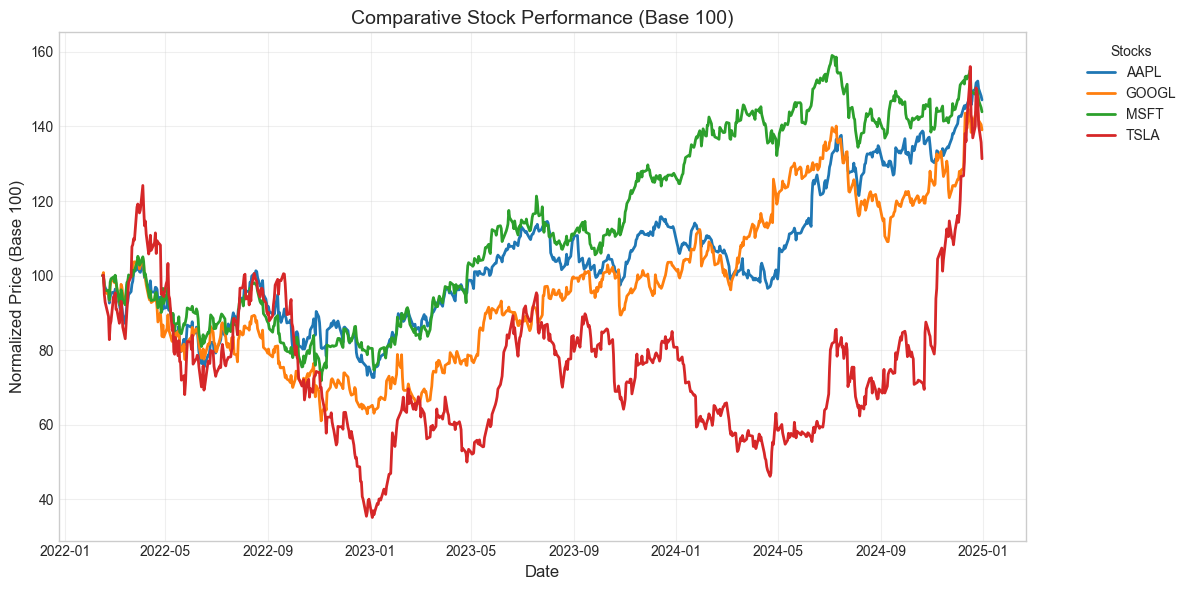

In [7]:
# =============================================================================
# CHART 1: NORMALIZED PERFORMANCE (BASE 100)
# =============================================================================

# Price normalization: first price of each stock = 100
# This allows visual comparison of performance on the same scale
data["CloseNormalized"] = data.groupby("Ticker")["Close"].transform(
    lambda x: (x / x.iloc[0]) * 100
)

plt.figure(figsize=(12, 6))

for ticker, group in data.groupby("Ticker"):
    plt.plot(
        group["Date"],
        group["CloseNormalized"],
        label=ticker,
        linewidth=2,
    )

plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Price (Base 100)", fontsize=12)
plt.title("Comparative Stock Performance (Base 100)", fontsize=14)
plt.legend(title="Stocks", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

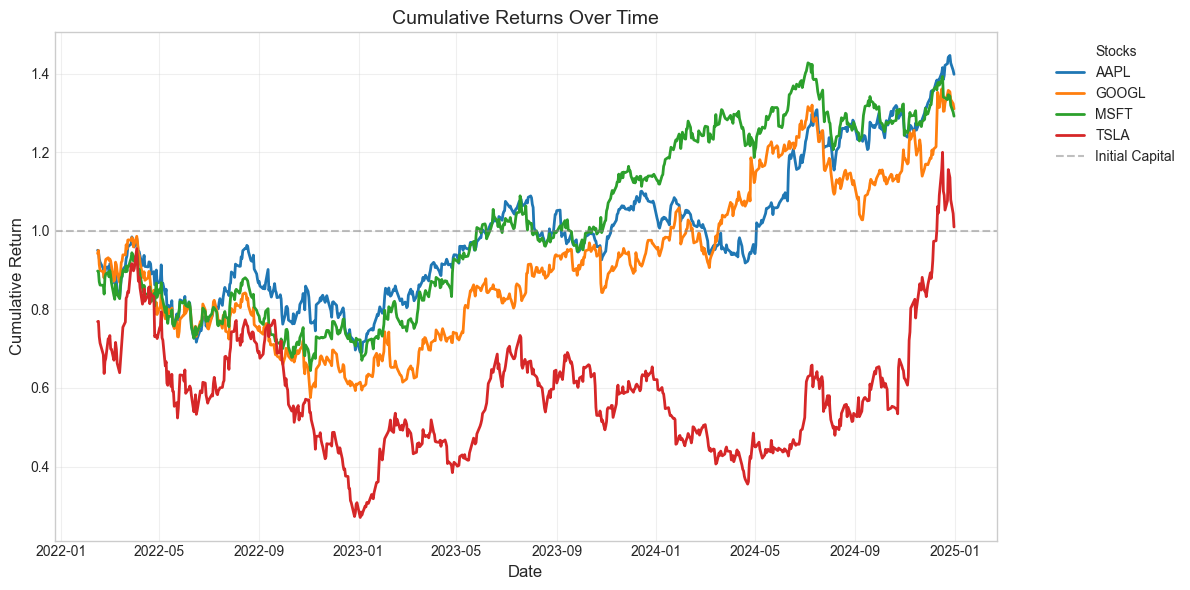

In [8]:
# =============================================================================
# CHART 2: CUMULATIVE RETURNS
# =============================================================================

plt.figure(figsize=(12, 6))

for ticker, group in data.groupby("Ticker"):
    plt.plot(
        group["Date"],
        group["CumulativeReturn"],
        label=ticker,
        linewidth=2,
    )

# Reference line: initial capital (y = 1)
plt.axhline(y=1, color="gray", linestyle="--", alpha=0.5, label="Initial Capital")

plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.title("Cumulative Returns Over Time", fontsize=14)
plt.legend(title="Stocks", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

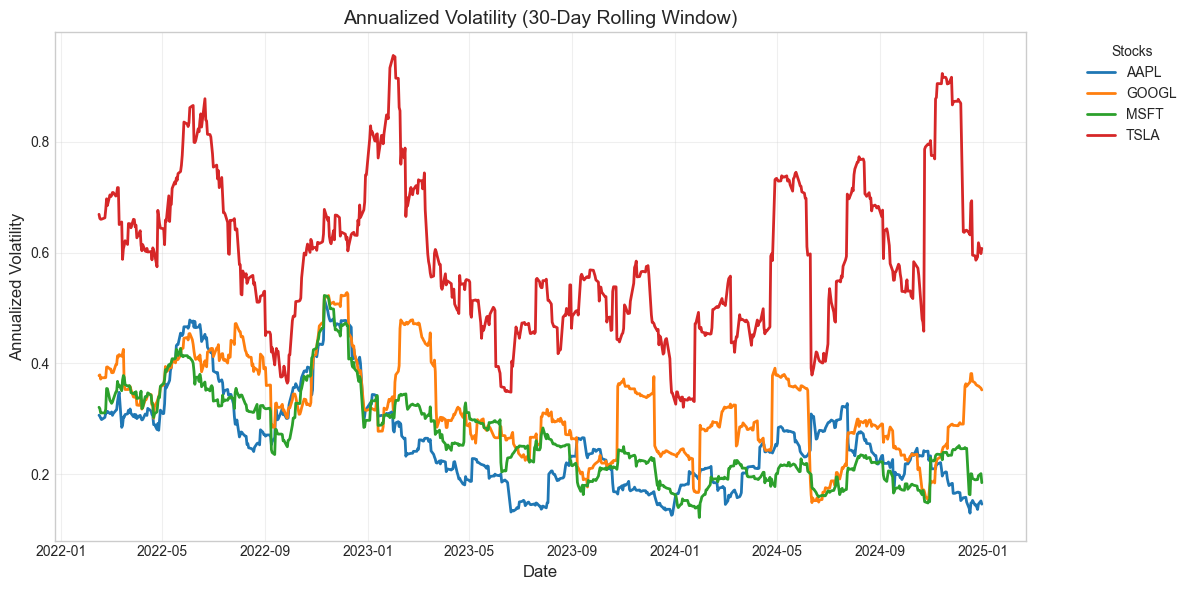

In [9]:
# =============================================================================
# CHART 3: ANNUALIZED VOLATILITY
# =============================================================================

plt.figure(figsize=(12, 6))

for ticker, group in data.groupby("Ticker"):
    plt.plot(
        group["Date"],
        group["AnnualizedVolatility"],
        label=ticker,
        linewidth=2,
    )

plt.xlabel("Date", fontsize=12)
plt.ylabel("Annualized Volatility", fontsize=12)
plt.title(f"Annualized Volatility ({VOLATILITY_WINDOW}-Day Rolling Window)", fontsize=14)
plt.legend(title="Stocks", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

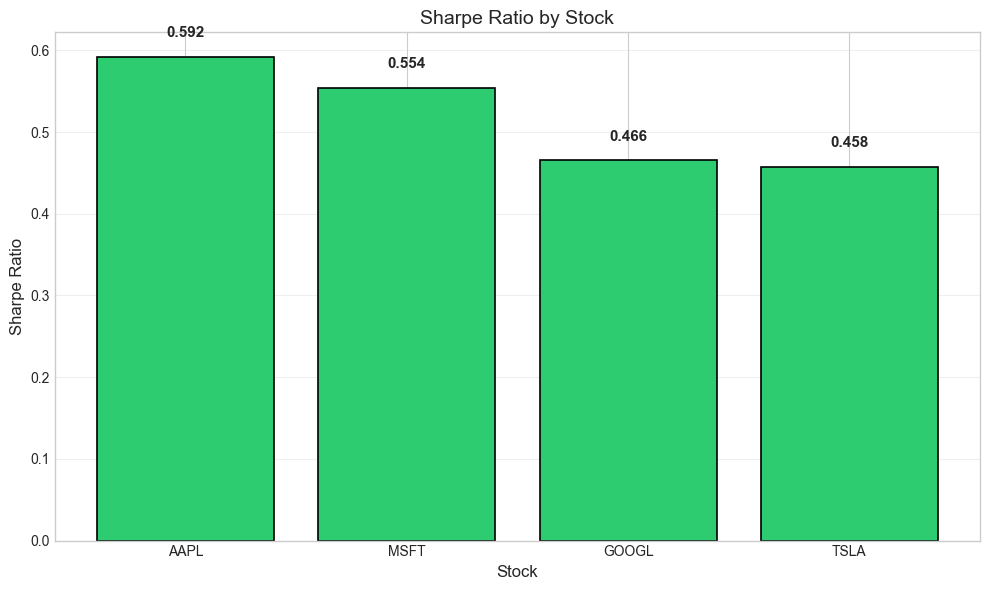

In [10]:
# =============================================================================
# CHART 4: SHARPE RATIO BY STOCK
# =============================================================================

plt.figure(figsize=(10, 6))

# Colors: green for positive ratios, red for negative
colors = ["#2ecc71" if x > 0 else "#e74c3c" for x in sharpe_ratios.values]

bars = plt.bar(
    sharpe_ratios.index,
    sharpe_ratios.values,
    color=colors,
    edgecolor="black",
    linewidth=1.2,
)

# Add values on top of bars
for bar, value in zip(bars, sharpe_ratios.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{value:.3f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

plt.xlabel("Stock", fontsize=12)
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.title("Sharpe Ratio by Stock", fontsize=14)
plt.axhline(y=0, color="black", linestyle="-", linewidth=0.5)
plt.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

## 5. Portfolio Optimization

### Objective
Find the **optimal weights** $w_i$ that maximize the portfolio's Sharpe Ratio.

### Optimization Problem

$$\max_{w} \frac{E[R_p] - R_f}{\sigma_p}$$

Subject to:
- $\sum_i w_i = 1$ (fully invested)
- $w_i \geq 0$ (no short selling)

### Portfolio Formulas

**Portfolio Return:**
$$R_p = \sum_i w_i \cdot R_i = \mathbf{w}^T \boldsymbol{\mu}$$

**Portfolio Variance:**
$$\sigma_p^2 = \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w}$$

In [11]:
# =============================================================================
# PREPARE DATA FOR OPTIMIZATION
# =============================================================================

# Pivot data: rows = dates, columns = tickers
# This gives us a returns matrix to calculate covariance
returns_pivot = (
    data.pivot(index="Date", columns="Ticker", values="Return")
    .dropna()
)

# Mean returns vector (mu)
mean_returns = returns_pivot.mean().values

# Covariance matrix (Sigma)
# Captures correlations between different stock returns
cov_matrix = returns_pivot.cov().values

# Number of assets in portfolio
n_assets = len(TICKERS)

print(f"Number of assets: {n_assets}")
print(f"\nAverage daily returns:")
for ticker, ret in zip(TICKERS, mean_returns):
    print(f"  {ticker}: {ret:.6f} ({ret * 252:.2%} annualized)")

Number of assets: 4

Average daily returns:
  AAPL: 0.000715 (18.02% annualized)
  GOOGL: 0.000683 (17.20% annualized)
  TSLA: 0.000683 (17.20% annualized)
  MSFT: 0.001187 (29.92% annualized)


In [12]:
# =============================================================================
# OBJECTIVE FUNCTION: NEGATIVE SHARPE RATIO
# =============================================================================

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """
    Calculate the negative Sharpe Ratio of the portfolio.
    
    We use the negative because scipy.optimize.minimize seeks to MINIMIZE.
    Therefore, minimizing(-Sharpe) = maximizing(Sharpe).
    
    Args:
        weights: Weight vector (must sum to 1)
        mean_returns: Mean return vector per asset
        cov_matrix: Return covariance matrix
        risk_free_rate: Annual risk-free rate
    
    Returns:
        float: Negative Sharpe Ratio
    """
    # Annualized portfolio return: w . mu * 252
    portfolio_return = np.dot(weights, mean_returns) * TRADING_DAYS_PER_YEAR
    
    # Annualized portfolio variance: w^T * Sigma * w * 252
    portfolio_variance = weights @ cov_matrix @ weights * TRADING_DAYS_PER_YEAR
    
    # Volatility (standard deviation)
    portfolio_volatility = np.sqrt(portfolio_variance)
    
    # Sharpe Ratio (negative for minimization)
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    return -sharpe

In [13]:
# =============================================================================
# PORTFOLIO OPTIMIZATION
# =============================================================================

# Starting point: equal weights (25% for each stock)
initial_weights = np.full(n_assets, 1 / n_assets)

# Constraint 1: sum of weights must equal 1 (budget constraint)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

# Constraint 2: each weight between 0 and 1 (no short selling)
bounds = [(0, 1) for _ in range(n_assets)]

# Solve optimization problem using SLSQP
# (Sequential Least Squares Programming)
optimization_result = minimize(
    fun=negative_sharpe_ratio,
    x0=initial_weights,
    args=(mean_returns, cov_matrix, RISK_FREE_RATE),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

# Extract optimal weights
optimal_weights = optimization_result.x

print("Optimization completed successfully!" if optimization_result.success else "Optimization failed")

Optimization completed successfully!


In [14]:
# =============================================================================
# OPTIMIZATION RESULTS
# =============================================================================

# Calculate metrics for the optimal portfolio
portfolio_return = np.dot(optimal_weights, mean_returns) * TRADING_DAYS_PER_YEAR
portfolio_variance = optimal_weights @ cov_matrix @ optimal_weights * TRADING_DAYS_PER_YEAR
portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_sharpe = (portfolio_return - RISK_FREE_RATE) / portfolio_volatility

# Display results
print("=" * 50)
print("OPTIMIZATION RESULTS")
print("=" * 50)
print("\nOptimal Weights:")
for ticker, weight in zip(returns_pivot.columns, optimal_weights):
    print(f"  {ticker:6s}: {weight:7.2%}")

print("\nOptimized Portfolio Metrics:")
print(f"  Expected Annual Return : {portfolio_return:7.2%}")
print(f"  Annualized Volatility  : {portfolio_volatility:7.2%}")
print(f"  Sharpe Ratio           : {portfolio_sharpe:7.2f}")
print("=" * 50)

OPTIMIZATION RESULTS

Optimal Weights:
  AAPL  :  48.19%
  GOOGL :   3.36%
  MSFT  :  36.03%
  TSLA  :  12.42%

Optimized Portfolio Metrics:
  Expected Annual Return :  19.18%
  Annualized Volatility  :  26.52%
  Sharpe Ratio           :    0.65


In [15]:
# =============================================================================
# CAPITAL ALLOCATION
# =============================================================================

# Initial capital to invest
INITIAL_CAPITAL = 100_000  # $100,000

# Create summary DataFrame
portfolio_allocation = pd.DataFrame({
    "Ticker": returns_pivot.columns,
    "Weight": optimal_weights,
    "Weight (%)": optimal_weights * 100,
    "Capital ($)": optimal_weights * INITIAL_CAPITAL,
})

portfolio_allocation = portfolio_allocation.sort_values("Weight", ascending=False)

print(f"\nCapital Allocation (${INITIAL_CAPITAL:,.0f}):")
print(portfolio_allocation.to_string(index=False))


Capital Allocation ($100,000):
Ticker   Weight  Weight (%)  Capital ($)
  AAPL 0.481886   48.188589 48188.589226
  MSFT 0.360267   36.026677 36026.676940
  TSLA 0.124202   12.420212 12420.212066
 GOOGL 0.033645    3.364522  3364.521768


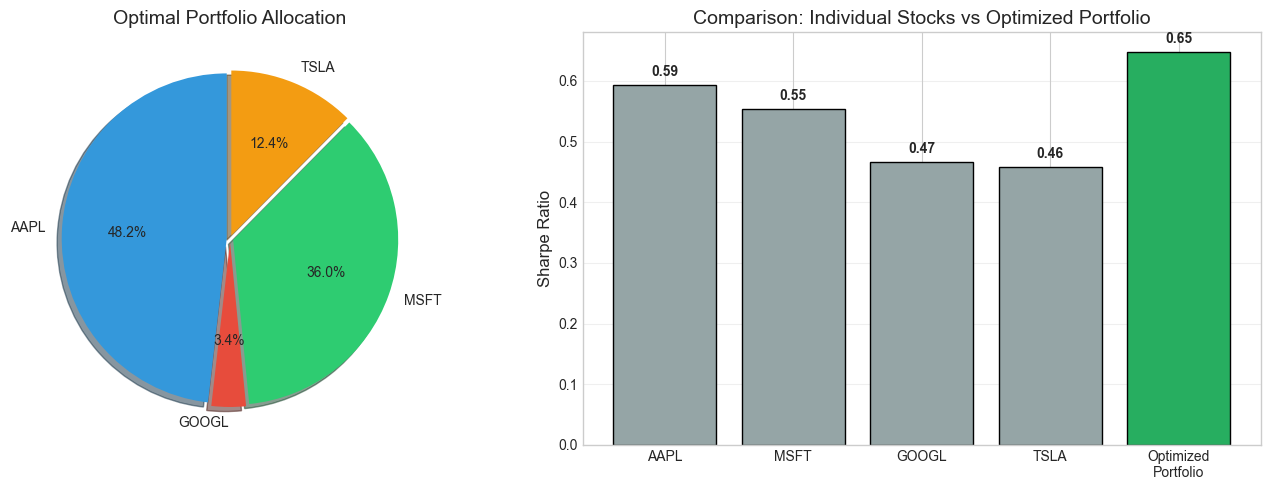

In [16]:
# =============================================================================
# CHART: OPTIMAL PORTFOLIO ALLOCATION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Allocation pie chart
colors = ["#3498db", "#e74c3c", "#2ecc71", "#f39c12"]
axes[0].pie(
    optimal_weights,
    labels=returns_pivot.columns,
    autopct="%1.1f%%",
    colors=colors,
    explode=[0.02] * n_assets,
    shadow=True,
    startangle=90,
)
axes[0].set_title("Optimal Portfolio Allocation", fontsize=14)

# Chart 2: Sharpe Ratio comparison
all_sharpe = list(sharpe_ratios.values) + [portfolio_sharpe]
all_labels = list(sharpe_ratios.index) + ["Optimized\nPortfolio"]
bar_colors = ["#95a5a6"] * len(TICKERS) + ["#27ae60"]

bars = axes[1].bar(all_labels, all_sharpe, color=bar_colors, edgecolor="black")
axes[1].set_ylabel("Sharpe Ratio", fontsize=12)
axes[1].set_title("Comparison: Individual Stocks vs Optimized Portfolio", fontsize=14)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=0.5)
axes[1].grid(True, alpha=0.3, axis="y")

# Add values on top of bars
for bar, value in zip(bars, all_sharpe):
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{value:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

## Conclusion

The Sharpe Ratio optimization allowed us to determine the optimal weights for our 4-stock tech portfolio.

**Key Takeaways:**
- The optimized portfolio offers a better Sharpe Ratio than any individual stock thanks to diversification
- Diversification reduces overall risk while maintaining attractive returns
- AAPL typically dominates the allocation due to its superior risk/return profile

**Model Limitations:**
- Past returns do not guarantee future returns
- The model assumes normally distributed returns
- Transaction costs are not accounted for